# test_xesmf

#### see https://xesmf.readthedocs.io/en/latest/notebooks/Rectilinear_grid.html

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import xarray as xr
import xesmf as xe

In [7]:
from dask.distributed import Client
client = Client(threads_per_worker=1)
client

/g/data/v14/tm4888/miniconda3/envs/pangeo_xesmf/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43451 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/43451/status,
Dashboard: /proxy/43451/status,Workers: 4
Total threads: 4,Total memory: 18.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42497,Workers: 4
Dashboard: /proxy/43451/status,Total threads: 4
Started: Just now,Total memory: 18.00 GiB
Comm: tcp://127.0.0.1:37087,Total threads: 1
Dashboard: /proxy/35565/status,Memory: 4.50 GiB
Nanny: tcp://127.0.0.1:41545,


In [8]:
ds = xr.tutorial.open_dataset(
    "air_temperature"
)  # use xr.tutorial.load_dataset() for xarray<v0.11.0
ds

<xarray.Dataset>
Dimensions:  (lat: 25, time: 2920, lon: 53)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Data variables:
    air      (time, lat, lon) float32 ...
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

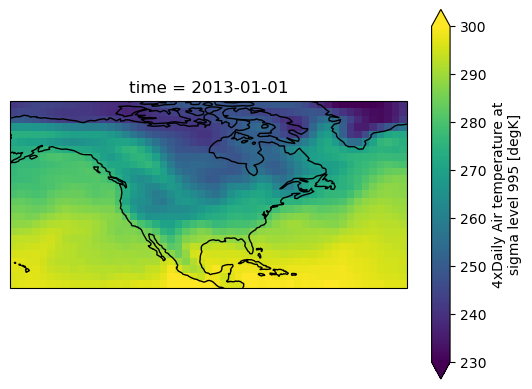

In [10]:
dr = ds["air"]  # get a DataArray
ax = plt.axes(projection=ccrs.PlateCarree())
dr.isel(time=0).plot.pcolormesh(ax=ax, vmin=230, vmax=300)
ax.coastlines()

# regrid

In [12]:
ds_out = xr.Dataset(
    {
        "lat": (["lat"], np.arange(16, 75, 1.0), {"units": "degrees_north"}),
        "lon": (["lon"], np.arange(200, 330, 1.5), {"units": "degrees_east"}),
    }
)
ds_out

<xarray.Dataset>
Dimensions:  (lat: 59, lon: 87)
Coordinates:
  * lat      (lat) float64 16.0 17.0 18.0 19.0 20.0 ... 70.0 71.0 72.0 73.0 74.0
  * lon      (lon) float64 200.0 201.5 203.0 204.5 ... 324.5 326.0 327.5 329.0
Data variables:
    *empty*

In [13]:
regridder = xe.Regridder(ds, ds_out, "conservative")
regridder  # print basic regridder information.

xESMF Regridder 
Regridding algorithm:       conservative 
Weight filename:            conservative_25x53_59x87.nc 
Reuse pre-computed weights? False 
Input grid shape:           (25, 53) 
Output grid shape:          (59, 87) 
Periodic in longitude?      False

In [14]:
dr_out = regridder(dr, keep_attrs=True)
dr_out

<xarray.DataArray 'air' (time: 2920, lat: 59, lon: 87)>
array([[[296.1936 , 296.4933 , 296.64383, ..., 296.6239 , 296.57   ,
         296.35767],
        [295.9    , 296.09998, 296.19998, ..., 295.9    , 295.9    ,
         295.43332],
        [295.9    , 296.09998, 296.19998, ..., 295.9    , 295.9    ,
         295.43332],
        ...,
        [243.79999, 244.26666, 244.5    , ..., 233.63335, 235.29999,
         237.96663],
        [243.79999, 244.26666, 244.5    , ..., 233.63335, 235.29999,
         237.96663],
        [241.87102, 242.6313 , 243.01498, ..., 233.68292, 235.44838,
         237.66943]],

       [[296.26776, 296.8064 , 297.0761 , ..., 296.19287, 296.17752,
         296.2103 ],
        [296.19998, 296.53333, 296.69998, ..., 295.56668, 295.5    ,
         295.23334],
        [296.19998, 296.53333, 296.69998, ..., 295.56668, 295.5    ,
         295.23334],
...
        [249.89   , 249.49   , 249.29   , ..., 241.69   , 242.48999,
         243.68997],
        [249.89   , 249.49   , 249.29   , ..., 241.69   , 242.48999,
         243.68997],
        [246.84814, 246.2443 , 245.9487 , ..., 243.05266, 243.60286,
         244.30954]],

       [[297.2945 , 297.6252 , 297.79266, ..., 296.21606, 296.0664 ,
         295.7324 ],
        [296.09   , 296.62332, 296.88998, ..., 295.69   , 295.69   ,
         295.35666],
        [296.09   , 296.62332, 296.88998, ..., 295.69   , 295.69   ,
         295.35666],
        ...,
        [249.89   , 249.49   , 249.29   , ..., 239.82333, 240.29   ,
         241.22331],
        [249.89   , 249.49   , 249.29   , ..., 239.82333, 240.29   ,
         241.22331],
        [246.3288 , 245.82306, 245.57744, ..., 241.16115, 241.18028,
         241.57034]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
  * lat      (lat) float64 16.0 17.0 18.0 19.0 20.0 ... 70.0 71.0 72.0 73.0 74.0
  * lon      (lon) float64 200.0 201.5 203.0 204.5 ... 324.5 326.0 327.5 329.0
Attributes:
    long_name:      4xDaily Air temperature at sigma level 995
    units:          degK
    precision:      2
    GRIB_id:        11
    GRIB_name:      TMP
    var_desc:       Air temperature
    dataset:        NMC Reanalysis
    level_desc:     Surface
    statistic:      Individual Obs
    parent_stat:    Other
    actual_range:   [185.16 322.1 ]
    regrid_method:  conservative

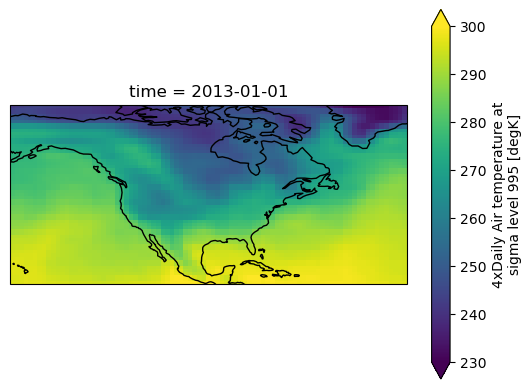

In [15]:
ax = plt.axes(projection=ccrs.PlateCarree())
dr_out.isel(time=0).plot.pcolormesh(ax=ax, vmin=230, vmax=300)
ax.coastlines()

# THE END

In [ ]:
client.shutdown()